In [1]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col,min,max,mean
import time
from pyspark.sql.functions import col, when, count,sum,split
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType, TimestampType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, sum, min, max, mean,countDistinct
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import year, month, dayofmonth, hour, datediff, lit
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, max as spark_max, sum as spark_sum, count as spark_count, col, udf
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
import datetime
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

In [2]:

schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True)
])


In [3]:


spark = SparkSession.builder \
    .appName("msprv3") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.cores", "6") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/23 13:09:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
octobre_df = spark.read.csv("/home/perso/Desktop/Data/2019-Oct.csv", header=True, schema=schema)
novembre_df = spark.read.csv("/home/perso/Desktop/Data/2019-Nov.csv", header=True, schema=schema)
decembre_df = spark.read.csv("/home/perso/Desktop/Data/2019-Dec.csv", header=True, schema=schema)
janvier_df = spark.read.csv("/home/perso/Desktop/Data/2020-Jan.csv", header=True, schema=schema)
fevrier_df = spark.read.csv("/home/perso/Desktop/Data/2020-Feb.csv", header=True, schema=schema)
mars_df = spark.read.csv("/home/perso/Desktop/Data/2020-Mar.csv", header=True, schema=schema)
avril_df = spark.read.csv("/home/perso/Desktop/Data/2020-Apr.csv", header=True, schema=schema)



In [ ]:
combined_df = (octobre_df
               .union(novembre_df)
               .union(decembre_df)
               .union(janvier_df)
               .union(fevrier_df)
               .union(mars_df)
               .union(avril_df))


In [ ]:
combined_df = combined_df.drop('brand', 'category_id', 'product_id', 'user_session')

In [ ]:
from pyspark.sql import DataFrame


def extract_primary_category(df: DataFrame, column_name: str) -> DataFrame:
    
    return df.withColumn(
        "primary_category",
        when(col(column_name).isNull(), "unknown")
        .otherwise(split(col(column_name), "\\.").getItem(0))  
    )




In [ ]:
combined_df = extract_primary_category(combined_df, "category_code")
combined_df.show()

In [ ]:
combined_df.select(countDistinct('primary_category')).collect()[0][0]

In [ ]:
combined_df.select('primary_category').distinct().show()

In [ ]:
combined_df = combined_df.drop('category_code')

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max as spark_max, sum as spark_sum, count as spark_count, unix_timestamp
from pyspark.sql.types import IntegerType
import datetime
from pyspark.sql.functions import udf




data = combined_df.withColumn("event_time", unix_timestamp(col("event_time"), "yyyy-MM-dd HH:mm:ss").cast("timestamp"))


last_date = data.agg(spark_max("event_time")).collect()[0][0] + datetime.timedelta(days=1)

recency_udf = udf(lambda x: (last_date - x).days, IntegerType())


intermediate_df = data.withColumn(
    "view", when(col("event_type") == "view", 1).otherwise(0)
).withColumn(
    "purchase_value", when(col("event_type") == "purchase", col("price")).otherwise(0)
)

# Définir la liste des catégories pour le pivot
categories = [
    "medicine", "computers", "auto", "unknown", "stationery",
    "sport", "apparel", "appliances", "country_yard", "furniture",
    "accessories", "kids", "electronics", "construction"
]

# Pivotement des données pour créer une colonne pour chaque catégorie et type de mesure
pivot_df = intermediate_df.groupBy("user_id").pivot(
    "primary_category", categories
).agg(
    count("view").alias("views"),
    sum("purchase_value").alias("total_purchase_value")
)

# Joindre le DataFrame pivoté avec la récence globale
# Calculer la récence globale en utilisant l'UDF et le dernier événement pour chaque utilisateur
global_recency = data.groupBy("user_id").agg(
    recency_udf(spark_max("event_time")).alias("global_recency")
)

final_df = pivot_df.join(global_recency, "user_id")

# Affichage du DataFrame résultant pour vérifier
final_df.show()


In [ ]:
for column in final_df.columns:
    if column != "global_recency":
        final_df = final_df.fillna({column: 0})


In [4]:
final_df=spark.read.parquet('/home/perso/Desktop/Data/final_df.parquet')

In [ ]:
final_df.show(10)

In [10]:
### sans pca  
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt



# Préparer les données
columns_of_interest = ['medicine_views', 'medicine_total_purchase_value',
                       'computers_views', 'computers_total_purchase_value',
                       'auto_views', 'auto_total_purchase_value',
                       'unknown_views', 'unknown_total_purchase_value',
                       'stationery_views', 'stationery_total_purchase_value',
                       'sport_views', 'sport_total_purchase_value',
                       'apparel_views', 'apparel_total_purchase_value',
                       'appliances_views', 'appliances_total_purchase_value',
                       'country_yard_views', 'country_yard_total_purchase_value',
                       'furniture_views', 'furniture_total_purchase_value',
                       'accessories_views', 'accessories_total_purchase_value',
                       'kids_views', 'kids_total_purchase_value',
                       'electronics_views', 'electronics_total_purchase_value',
                       'construction_views', 'construction_total_purchase_value',
                       'global_recency']

# Vérifier et gérer les valeurs manquantes
final_df = final_df.dropna(subset=columns_of_interest)

# Assembler les colonnes en un vecteur de fonctionnalités
assembler = VectorAssembler(inputCols=columns_of_interest, outputCol='features')
data = assembler.transform(final_df)

# Normaliser les fonctionnalités
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(data)
data_scaled = scaler_model.transform(data)

# Déterminer le nombre optimal de clusters (k) - Méthode du coude
cost = []
K = range(5, 20)  # Définir la plage de k à tester
for k in K:
    kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster', k=k, seed=42)
    model = kmeans.fit(data_scaled)
    cost.append(model.summary.trainingCost)




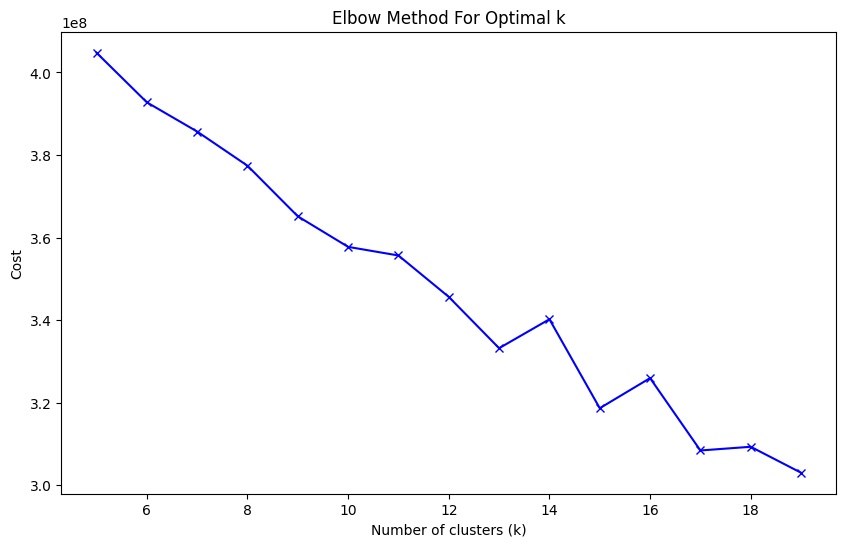

In [12]:
# Tracer la méthode du coude pour déterminer k
plt.figure(figsize=(10, 6))
plt.plot(K, cost, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

range(5, 20)

In [13]:
#sans pca

k_optimal = 10  # Remplacer par la valeur identifiée à partir du graphique

# Appliquer KMeans avec le k optimal choisi
kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster', k=k_optimal, seed=42)
model = kmeans.fit(data_scaled)

# Prédictions et centres des clusters
predictions = model.transform(data_scaled)
centroids = model.clusterCenters()

# Dénormaliser les centroids
means = scaler_model.mean.toArray()
std_devs = scaler_model.std.toArray()

real_centroids = [(centroid * std_devs + means).tolist() for centroid in centroids]

# Afficher les centroids dénormalisés
for i, real_centroid in enumerate(real_centroids):
    print(f"Cluster {i} real centroid: {real_centroid}")

# Afficher les données réelles associées à chaque cluster
result = predictions.select('user_id', 'cluster')
clustered_data = final_df.join(result, 'user_id')
#clustered_data.show(10)

Cluster 0 real centroid: [0.020262106469311824, 0.005274710053729201, 1.6886207363626, 4.348670475357233, 0.41782484211395, 0.7871422101162941, 6.025778838604527, 8.768860978712647, 0.01446077255538214, 0.00869832318657264, 1.3375459419679023, 2.9651402963929385, 3.5115497814282315, 4.602342061505131, 5.5183179167839045, 19.34492682999891, 0.06196173493862408, 0.02571804507298702, 1.4598047766705373, 1.745662097741356, 0.3798895841173372, 0.1690781320231763, 0.7857228677328695, 0.8034103301715058, 7.753622430379945, 57.817837387196604, 7.2161962595111, 80.08661937358224, 221.3843007420116]
Cluster 1 real centroid: [0.030569779165649142, 0.005644056406719514, 2.0407152271409754, 4.462428675528206, 0.4837998973127159, 0.8560489246391304, 6.936487159327296, 9.28091377246226, 0.019553963929183703, 0.00963208613579275, 2.0364201538198694, 4.257935392004438, 5.199938426295563, 6.747864396620156, 8.11422384943997, 26.908591984189492, 0.1011192160333581, 0.031997409144996256, 2.078667297963634

In [15]:

result.groupBy('cluster').agg(count('user_id').alias('user_count')).show()


+-------+----------+
|cluster|user_count|
+-------+----------+
|      1|   8746571|
|      5|       664|
|      9|      4387|
|      4|    422435|
|      7|     15785|
|      2|       208|
|      0|   6449711|
|      6|        23|
|      3|         1|
|      8|        18|
+-------+----------+



In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import pandas as pd


# Préparer les données
columns_of_interest = ['medicine_views', 'medicine_total_purchase_value',
                       'computers_views', 'computers_total_purchase_value',
                       'auto_views', 'auto_total_purchase_value',
                       'unknown_views', 'unknown_total_purchase_value',
                       'stationery_views', 'stationery_total_purchase_value',
                       'sport_views', 'sport_total_purchase_value',
                       'apparel_views', 'apparel_total_purchase_value',
                       'appliances_views', 'appliances_total_purchase_value',
                       'country_yard_views', 'country_yard_total_purchase_value',
                       'furniture_views', 'furniture_total_purchase_value',
                       'accessories_views', 'accessories_total_purchase_value',
                       'kids_views', 'kids_total_purchase_value',
                       'electronics_views', 'electronics_total_purchase_value',
                       'construction_views', 'construction_total_purchase_value',
                       'global_recency']



# Assembler les colonnes en un vecteur de fonctionnalités
assembler = VectorAssembler(inputCols=columns_of_interest, outputCol='features')
data = assembler.transform(final_df)

# Normaliser les fonctionnalités
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(data)
data_scaled = scaler_model.transform(data)

# Appliquer PCA
num_components = 10  # Choisir le nombre de composantes principales
pca = PCA(k=num_components, inputCol='scaled_features', outputCol='pca_features')
pca_model = pca.fit(data_scaled)
data_pca = pca_model.transform(data_scaled)

# Déterminer le nombre optimal de clusters (k) - Méthode du coude
cost = []
K = range(6, 20)  # Définir la plage de k à tester
for k in K:
    kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster', k=k, seed=42)
    model = kmeans.fit(data_pca)
    cost.append(model.summary.trainingCost)




24/06/23 13:11:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/06/23 13:11:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/23 13:11:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


"cost = []\nK = range(6, 20)  # Définir la plage de k à tester\nfor k in K:\n    kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster', k=k, seed=42)\n    model = kmeans.fit(data_pca)\n    cost.append(model.summary.trainingCost)"

In [ ]:
# Tracer la méthode du coude pour déterminer k
plt.figure(figsize=(10, 6))
plt.plot(K, cost, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
final_df.write.parquet('/home/perso/Desktop/Data/final_df.parquet')